# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- в избранном регионе ищут месторождения, для каждого определяют значения признаков
- строят модель и оценивают объём запасов
- выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины
- прибыль равна суммарной прибыли отобранных месторождений

Условия проекта:
- для обучения модели подходит только линейная регрессия (остальные недостаточно предсказуемые)
- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
- бюджет на разработку скважин в регионе - 10 млрд рублей
- при нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью

## Загрузка и подготовка данных

Загрузим нужные для работы библиотеки и загрузим и сохраним данные в переменную df

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

RANDOM_STATE_ = 12345

In [ ]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
except:
    df_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

<div class="alert alert-success">
<h2> Комментарий ревьюера ✔️ <a class="tocSkip"> </h2>

Здорово, что ты используешь конструкцию `try-except`, это повышает отказоустойчивость кода

</div>


In [ ]:
try:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
except:
    df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

In [ ]:
try:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [ ]:
display(df_0.head())
display(df_1.head())
display(df_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Опишем данные:

- id — уникальный идентификатор скважины

- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)

- product — объём запасов в скважине (тыс. баррелей)

In [ ]:
display(df_0.info())
display(df_1.info())
display(df_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Видим, что типы данных корректные, пропусков нет

In [ ]:
display(df_0.describe())
display(df_1.describe())
display(df_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Видим нулевые значения объёма запасов в скважине

Проверим данные на наличие явных дубликатов и уникальность значений

In [ ]:
print(df_0.duplicated().sum())
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())

0
0
0


In [ ]:
print(df_0.nunique())
print(df_1.nunique())
print(df_2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64
id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64
id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64


- в регионе 1 по параметру `product`только 12 уникальных значений из 10000
- есть пересечения по id в каждом из регионов

Проверим данные на артефакты по id

In [ ]:
df_0[df_0.duplicated(['id'])]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [ ]:
df_0[df_0['id'] == 'HZww2']

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


In [ ]:
df_0[df_0['id'] == 'bxg6G']

,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


Артефакты есть, но неизвестно какие значения из 2-х строк корректные, складывать эти данные также неправильно. Таких артефактов немного, примем решение использовать данные как с разных скважин

In [ ]:
df_1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

Регион один имеет другую дискретизацию - мы видим равное распределение, большое количество нулевых значений и низкое количество уникальных значений. Можно сделать предположение, что данные вручную подвергались категоризации, вследствие чего образовалось много нулевых значений. Природу такой дискретизации лучше всего будет уточнить у заказчика

Посмотрим на распределения признаков

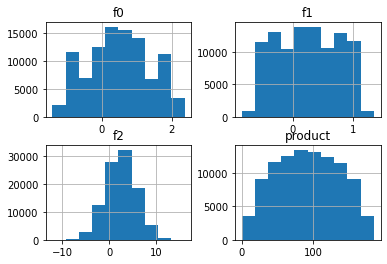

In [ ]:
df_0.hist();

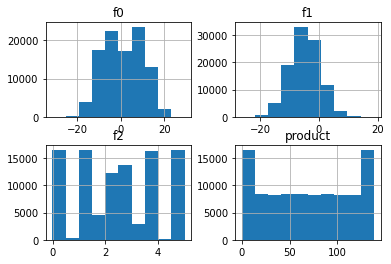

In [ ]:
df_1.hist();

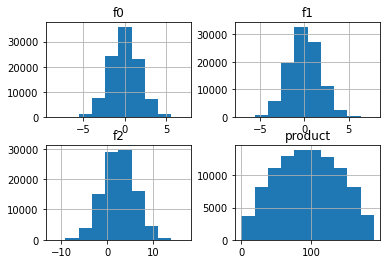

In [ ]:
df_2.hist();

In [ ]:
display(df_0.corr())
display(df_1.corr())
display(df_2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


В поисках нелинейной зависимости признаков построим диаграммы рассеивания

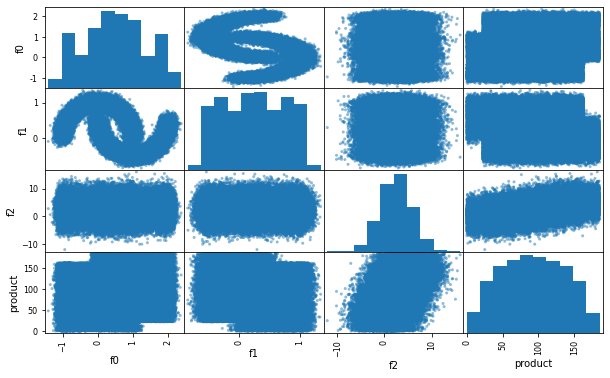

In [ ]:
pd.plotting.scatter_matrix(df_0, figsize=(10,6));

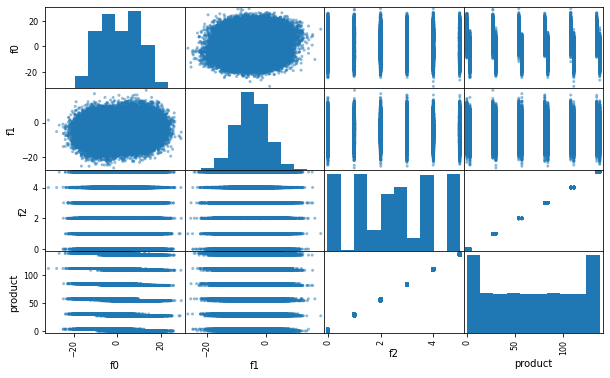

In [ ]:
pd.plotting.scatter_matrix(df_1, figsize=(10,6));

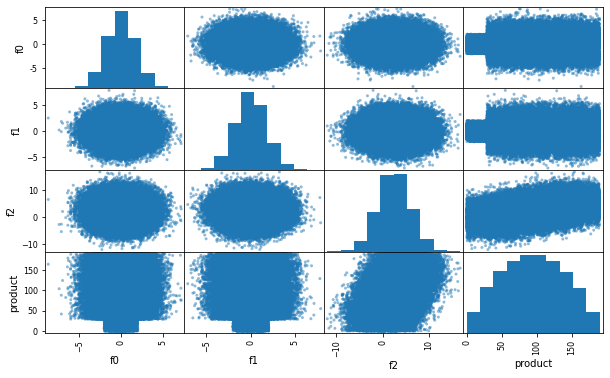

In [ ]:
pd.plotting.scatter_matrix(df_2, figsize=(10,6));

- наблюдаем интересные нелинейные зависимости признаков `f1` и `f0` в регионе 0
- в регионе 1 есть явно выраженные зависимости `f0` и `f1` с `f2` и `product`

**Выводы:**
- типы данных корректные, пропусков нет по всем регионам
- существуют строки с нулевыми значениями объёма запасов в скважине
- явных дубликатов нет, однако:
    - есть пересечения по id в каждом из регионов
    - в регионе 1 по параметру `product`только 12 уникальных значений из 10000. Пока сложно интерпретировать причину такого распределения значений. Малое количество уникальных значений в этом параметре может влиять на процесс и исход машинного обучения, будем иметь это ввиду
- во всех трёх регионах присутствует выраженная корреляция признака `f2` с признаком `product`, вместе с тем особенно сильная она в 1 регионе (более 0.99)
- наблюдаем интересные нелинейные зависимости признаков `f1` и `f0` в регионе 0, в регионе 1 есть явно выраженные зависимости `f0` и `f1` с `f2` и `product`
- в целях моделирования уникальный идентификатор скважины (id) не несет никакой информации, от него мы избавимся
- признаки имеют разный масштаб, соответственно перед исследованием прибегнем к стандартизации

Удалим столбцы с id

In [ ]:
df_0 = df_0.drop(['id'], axis=1)
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

## Обучение и проверка модели

Обучим и проверим модель для каждого региона. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)
- разобьём данные на обучающую и валидационную выборки в соотношении 75:25
- сохраним предсказания и правильные ответы на валидационной выборке
- найдём средний запас предсказанного сырья и RMSE модели, и проанализируем результаты

Напишем функцию: на вход она получает регион, делит его на признаки и таргет, разбивает данные на обучающую и валидационные выборки, стандартизирует данные и рассчитывает метрики RMSE

In [ ]:
def region_model(data):
    #разобьём данные на обучающую и валидационную выборки
    features = data.drop(['product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=RANDOM_STATE_)

    #стандартизируем данные
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.fit_transform(features_valid)

    #создадим модель линейной регрессии, найдем rmse и средние запасы
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    stock_mean = data['product'].mean()
    stock_mean_predictions = predictions.mean()
    return predictions, rmse, stock_mean, stock_mean_predictions, target_valid.reset_index(drop=True)

In [ ]:
pred_0, rmse_0, stock_mean_0, stock_mean_predictions_0, target_valid_0 = region_model(df_0)
print('RMSE по региону 0:', rmse_0)
print('Средний запас предсказанного сырья по региону 0, тыс. баррелей:', stock_mean_predictions_0)

RMSE по региону 0: 37.58010943632562
Средний запас предсказанного сырья по региону 0, тыс. баррелей: 92.64046775305692


In [ ]:
pred_1, rmse_1, stock_mean_1, stock_mean_predictions_1, target_valid_1 = region_model(df_1)
print('RMSE по региону 0:', rmse_1)
print('Средний запас предсказанного сырья по региону 0, тыс. баррелей:', stock_mean_predictions_1)

RMSE по региону 0: 0.910164709305544
Средний запас предсказанного сырья по региону 0, тыс. баррелей: 68.85895465854666


In [ ]:
pred_2, rmse_2, stock_mean_2, stock_mean_predictions_2, target_valid_2 = region_model(df_2)
print('RMSE по региону 0:', rmse_2)
print('Средний запас предсказанного сырья по региону 0, тыс. баррелей:', stock_mean_predictions_2)

RMSE по региону 0: 40.0303627970992
Средний запас предсказанного сырья по региону 0, тыс. баррелей: 95.03858906371521


**Выводы:**
    
- лучшие показатели RMSE модели в регионе 1 (RMSE = 0.91) - этот регион более предсказуем. Можно предположить, что причина в отредактированных данных

- средний запас предсказанного сырья по региону 1 = 68.858 тыс. баррелей, что меньше чем в двух других регионах

- значения RMSE в регионах 0 и 2 говорят о том, что модель работает хуже, и это дает более непредсказуемые результаты

## Подготовка к расчёту прибыли

Согласно условию:
- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
- бюджет на разработку скважин в регионе — 10 млрд рублей
- один баррель сырья приносит 450 рублей дохода (доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей)

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирать регион с наибольшей средней прибылью.

Все ключевые значения для расчётов сохраним в отдельных переменных

In [ ]:
TOTAL_WELLS = 500
BEST_WELLS = 200
BUDGET = 10000000
BARREL_REVENUE = 450
PROBABILITY_LOSSES = 0.025

- рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
- сравним полученный объём сырья со средним запасом в каждом регионе.

In [ ]:
drilling_cost = BUDGET / BEST_WELLS
print('Бюджет бурения одного месторождения, тыс. рублей:', int(drilling_cost))

Бюджет бурения одного месторождения, тыс. рублей: 50000


In [ ]:
print('Объём сырья для безубыточной разработки новой скважины, тыс. баррелей:', drilling_cost / BARREL_REVENUE)

Объём сырья для безубыточной разработки новой скважины, тыс. баррелей: 111.11111111111111


In [ ]:
print('Средний запас сырья региона 0, тыс. баррелей:', stock_mean_0)
print('Средний запас сырья региона 1, тыс. баррелей:', stock_mean_1)
print('Средний запас сырья региона 2, тыс. баррелей:', stock_mean_2)

Средний запас сырья региона 0, тыс. баррелей: 92.50000000000001
Средний запас сырья региона 1, тыс. баррелей: 68.82500000000002
Средний запас сырья региона 2, тыс. баррелей: 95.00000000000004


**Выводы:**

- бюджет бурения одного месторождения - 50000 тыс. рублей
- необходимый объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей
- средний запас сырья в скважинах меньше, чем достаточный объём сырья для безубыточной разработки новой скважины

## Расчёт прибыли и рисков

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- выберем скважины с максимальными значениями предсказаний
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
- рассчитаем прибыль для полученного объёма сырья

In [ ]:
def profit(prediction, target):
    data = pd.concat([prediction, target], axis=1)
    data.columns = ['prediction','target']
    data = data.sort_values(by='prediction', ascending=False)
    data = data[:BEST_WELLS]
    return (data['target'].sum() * BARREL_REVENUE - BUDGET)

In [ ]:
revenue_0 = profit(pred_0, target_valid_0)

print('Прибыль для полученного объёма сырья региона 0, млн. руб:', revenue_0 / 1000)

Прибыль для полученного объёма сырья региона 0, млн. руб: 3320.8260431398526


In [ ]:
revenue_1 = profit(pred_1, target_valid_1)

print('Прибыль для полученного объёма сырья региона 1, млн. руб:', revenue_1 / 1000)

Прибыль для полученного объёма сырья региона 1, млн. руб: 2415.0866966815124


In [ ]:
revenue_2 = profit(pred_2, target_valid_2)

print('Прибыль для полученного объёма сырья региона 2, млн. руб:', revenue_2 / 1000)

Прибыль для полученного объёма сырья региона 2, млн. руб: 2710.349963599833


Посчитаем риски и прибыль для каждого региона:
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
- найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков
- предложим регион для разработки скважин и обоснуем выбор

In [ ]:
def bootstrap(prediction, target):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        pred_subsample = prediction[target_subsample.index]
        values.append(profit(pred_subsample, target_subsample))

    values = pd.Series(values)
    mean = np.mean(values) / 1000

    lower = values.quantile(0.025) / 1000
    upper = values.quantile(0.975) / 1000

    confidence_interval = (lower, upper)
    risk_loss = (values < 0).mean() * 100

    print('Средняя прибыль, млн. рублей', mean)
    print('95% доверительный интервал от', lower, 'до', upper, 'млн. рублей')
    print('Процент риска', risk_loss, '%')

In [ ]:
region_0 = bootstrap(pred_0, target_valid_0)

Средняя прибыль, млн. рублей 395.86551198497347
95% доверительный интервал от -108.9542256755867 до 909.105814835893 млн. рублей
Процент риска 7.000000000000001 %


In [ ]:
region_1 = bootstrap(pred_1, target_valid_1)

Средняя прибыль, млн. рублей 456.0436751904983
95% доверительный интервал от 33.820509398983845 до 852.2894538660345 млн. рублей
Процент риска 1.5 %


In [ ]:
region_2 = bootstrap(pred_2, target_valid_2)

Средняя прибыль, млн. рублей 404.4049302502108
95% доверительный интервал от -163.3504133955995 до 950.3595749238009 млн. рублей
Процент риска 7.6 %


**Общие выводы:**

- изучены предоставленные данные трёх регионов, обучена модель линейной регрессии и предложен расчёт прибыли и рисков для каждого региона
- регион 1 - единственный, у которого доверительный интервал не уходит в минус
- наиболее перспективный - регион 1. Добыча нефти в нем связана с наименьшим риском и предполагает получение наибольшой средней прибыли
- регион 0 и регион 2 имеют вероятность убытков больше 2.5% (более чем в 2 и 3 раза соответственно), что не соответствует условию поставленной задачи